In [15]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [16]:
from utils.data_preprocess import read_sample, encode_label
from utils.embedding_loader import read_sentence_embedding

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss, confusion_matrix, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import StepLR

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

torch.manual_seed(100)
np.random.seed(10)

In [17]:
# sample_fn = "../../data/test_sample.xlsx"
sample_fn = "../../data/medical_sieve_training_set1.xlsx"
data = read_sample(sample_fn)
data.head(2)

,aspect,course_of_problem,group,id,text,trainOrtest,treatment,ground_truth_subaspect,ground_truth_sentiment
0,[3],[],Genital_Herpes_Simplex,Genital_Herpes_Simplex-285020-1-5,used to it and u will realise that this does n...,train,[],['not about'],1
1,[3],[],Polymyalgia_Rheumatica_and_GCA,Polymyalgia_Rheumatica_and_GCA-437988-1-9,They are available on the Patient UK NE site a...,train,[],['not about'],0


In [18]:
columns = ["text", "ground_truth_subaspect"]
aspect_data = data[columns]
aspect_data.head(2)

,text,ground_truth_subaspect
0,used to it and u will realise that this does n...,['not about']
1,They are available on the Patient UK NE site a...,['not about']


In [19]:
aspect_data["ground_truth_subaspect"].value_counts()/aspect_data.shape[0]

['not about']                                                 0.621672
['access-2']                                                  0.078467
['costs-2']                                                   0.061829
['errors-1']                                                  0.039502
['access-1']                                                  0.039341
['errors-2']                                                  0.020127
['delays-2']                                                  0.020127
['access-3']                                                  0.017658
['costs-1']                                                   0.017282
['delays-1']                                                  0.017014
['delays-3']                                                  0.014116
['costs-4']                                                   0.011217
['access-3', 'access-2']                                      0.010305
['access-2', 'access-1']                                      0.009768
['erro

In [20]:
encoded_labels, classes = encode_label(aspect_data["ground_truth_subaspect"])    

In [21]:
print(classes.shape)
classes

(15,)


array(['access-1', 'access-2', 'access-3', 'access-4', 'costs-1',
       'costs-2', 'costs-3', 'costs-4', 'delays-1', 'delays-2',
       'delays-3', 'errors-1', 'errors-2', 'errors-3', 'not about'],
      dtype=object)

In [22]:
embedding_fn = "../../data/embedding/medical_sieve_training_set1__cbow.txt"
wv = read_sentence_embedding().values

In [23]:
class FcLayer(nn.Module):
    def __init__(self, in_dims, out_dims, dropout_rate):
        super(FcLayer, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(in_dims, out_dims),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.BatchNorm1d(out_dims)
        )
    
    def forward(self, X):
        out = self.fc(X)
        return out          

class NNBaseline(nn.Module):
    def __init__(self, dims, dropout_rates):
        super(NNBaseline, self).__init__()
        
        N = len(dims)
        self.fcs = nn.ModuleList([FcLayer(dims[i], dims[i+1], dropout_rates[i]) for i in range(N - 2)])
        self.out_fc = nn.Linear(dims[-2], dims[-1])
    
    def forward(self, X):
        out = X
        for fc in self.fcs:
            out = fc(out)
        out = self.out_fc(out)
        return out         

In [24]:
def eval_metric(y_true, y_pred):
    metric = hamming_loss(y_true, y_pred)
    return metric

def convert_logits_to_label(logits):
    logits = logits > 9e-2
    logits = logits.astype(int)
    return logits

def generate_loaders_from_numpy(X, y):    
    X_tensor = torch.from_numpy(X).float()
    y_tensor = torch.from_numpy(y).float()
    dataset = TensorDataset(X_tensor, y_tensor)
    
    N = X.shape[0]
    
    train_size = int(N*0.8)
    val_size = N - train_size
    
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])    
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
    val_loader = DataLoader(dataset=val_dataset, batch_size=val_size)    

    return train_loader, val_loader

def make_single_train_step(net, loss_fn, optimizer):
    
    def train_step(X, y):
        
        net.train()
        
        y_pred = net(X)
        loss = loss_fn(y, y_pred)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        return loss.item()
    
    return train_step
        
    
def make_validation(net, loss, optimizer):
    
    def validate(X, y):
        
        net.eval()        
        
        with torch.no_grad():
            y_pred = net(X)
            loss = loss_fn(y, y_pred)    
            
            logits = torch.sigmoid(y_pred)
            y_pred_labels = convert_logits_to_label(logits.numpy())            
            metric = eval_metric(y.numpy(), y_pred_labels)
        return loss.item(), metric
    
    return validate

def make_evaluation(net, loss):
    
    def evaluate(X, y):        
        net.eval()        
        
        with torch.no_grad():
            y_pred = net(X)
            loss = loss_fn(y, y_pred)    
            
            logits = torch.sigmoid(y_pred)
            y_pred_labels = convert_logits_to_label(logits.numpy())            
            for idx in range(y_pred_labels.shape[1]):
                print("label %d, confusion matrix:" % (idx + 1))
                print(confusion_matrix(y[:, idx], y_pred_labels[:, idx]))
                print("f1")
                print(f1_score(y[:, idx], y_pred_labels[:, idx]))
                                
        return loss.item()
    return evaluate        

def train(X, y, n_epochs=10, batch_size=32, lr=1e-4, net=None, loss_fn=None, optimizer=None, device=None):
    
    train_loader, val_loader = generate_loaders_from_numpy(X, y)
    val_data = next(iter(val_loader))
    
    train_step = make_single_train_step(net, loss_fn, optimizer)
    validate_step = make_validation(net, loss_fn, optimizer)
    evaludate_step = make_evaluation(net, loss_fn)
    
#     scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    losses = []
    val_losses = []
    metrics = []
    for epoch in range(n_epochs):
        for idx, (X_batch, y_batch) in enumerate(train_loader):
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            loss = train_step(X_batch, y_batch)
            
            if idx % 100 == 0:
                losses.append(loss)                
                eval_loss, metric = validate_step(val_data[0], val_data[1])
                val_losses.append(eval_loss)
                metrics.append(metric)
                print("epoch: %d, iter: %d, training loss: %f, eval loss: %f, hamming loss: %f" % (epoch, idx, loss, eval_loss, metric))                
                
#         scheduler.step()
    
    evaludate_step(val_data[0], val_data[1])
    
    return net, losses, val_losses, metrics
    

In [25]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [26]:
n_epochs = 20
batch_size = 64
lr = 1e-4
dims = [wv.shape[1], 1000, 500, 200, encoded_labels.shape[1]]
dropout_rates = [0.1, 0.5, 0.5, 0.5]

In [27]:
def multilabel_loss(y_true, y_pred):
    output = nn.functional.binary_cross_entropy_with_logits(y_pred, y_true)
    return output

In [28]:
net = NNBaseline(dims, dropout_rates)
optimizer = optim.Adam(net.parameters(), lr=lr)
loss_fn = multilabel_loss

model, losses, val_losses, metrics = train(wv, encoded_labels, n_epochs=n_epochs, batch_size=batch_size, lr=lr, net=net, loss_fn=loss_fn, optimizer=optimizer, device=device)


epoch: 0, iter: 0, training loss: 0.744773, eval loss: 0.695916, hamming loss: 0.930901
epoch: 0, iter: 100, training loss: 0.710193, eval loss: 0.684365, hamming loss: 0.930847
epoch: 0, iter: 200, training loss: 0.695214, eval loss: 0.668351, hamming loss: 0.929398
epoch: 1, iter: 0, training loss: 0.678698, eval loss: 0.664220, hamming loss: 0.928969
epoch: 1, iter: 100, training loss: 0.640604, eval loss: 0.625163, hamming loss: 0.927913
epoch: 1, iter: 200, training loss: 0.597579, eval loss: 0.588992, hamming loss: 0.927019
epoch: 2, iter: 0, training loss: 0.576672, eval loss: 0.572863, hamming loss: 0.926733
epoch: 2, iter: 100, training loss: 0.507783, eval loss: 0.492404, hamming loss: 0.926876
epoch: 2, iter: 200, training loss: 0.443859, eval loss: 0.428941, hamming loss: 0.926769
epoch: 3, iter: 0, training loss: 0.418563, eval loss: 0.400019, hamming loss: 0.927001
epoch: 3, iter: 100, training loss: 0.350218, eval loss: 0.343011, hamming loss: 0.926751
epoch: 3, iter: 20

/Users/zhengcao/anaconda3/envs/csci566/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


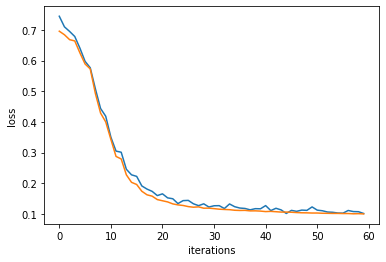

In [29]:
plt.plot(np.arange(len(losses)), losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.ylabel("loss")
plt.xlabel("iterations")
plt.show()

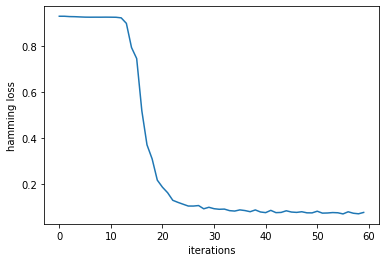

In [30]:
plt.plot(np.arange(len(metrics)), metrics)
plt.ylabel("hamming loss")
plt.ylabel("hamming loss")
plt.xlabel("iterations")
plt.show()